#SeNet과 ResNet 구현 및 비교하기

## 0. Google Drive 마운트

- Google Drive를 Colab에 마운트하여 준비해둔 데이터셋 파일에 접근

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 데이터 압축 해제

- tarfile로 압축 해제

In [2]:
import os
import tarfile

# Caltech-101 데이터셋이 들어있는 폴더 경로 (Drive 경로에 맞게 수정)
caltech_dir = "/content/drive/MyDrive/caltech-101"

img_tar_path = os.path.join(caltech_dir, "101_ObjectCategories.tar.gz")
extracted_img_dir = os.path.join(caltech_dir, "101_ObjectCategories")

if not os.path.exists(extracted_img_dir):
    print("101_ObjectCategories.tar.gz 압축 해제 중...")
    with tarfile.open(img_tar_path, "r:gz") as tar:
        tar.extractall(path=caltech_dir)
    print("이미지 데이터 압축 해제 완료!")
else:
    print("이미지 데이터 폴더가 이미 존재합니다.")

img_data_dir = extracted_img_dir

101_ObjectCategories.tar.gz 압축 해제 중...
이미지 데이터 압축 해제 완료!
Annotations.tar 추출 중...
어노테이션 데이터 추출 완료!


## 1 - 1. 데이터셋 구조 확인

- 폴더 내 이미지 파일명을 출력하여 데이터 구조를 확인

In [3]:
# 폴더(클래스) 리스트 확인
categories = sorted([folder for folder in os.listdir(img_data_dir)
                     if os.path.isdir(os.path.join(img_data_dir, folder))])
print("전체 클래스(폴더) 리스트:")
for cat in categories:
    print(" -", cat)

# 각 클래스 폴더 내의 이미지 파일명 출력 (jpg, jpeg, png 파일만)
for cat in categories:
    cat_path = os.path.join(img_data_dir, cat)
    image_files = sorted([fname for fname in os.listdir(cat_path)
                          if fname.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"\n클래스: {cat} ({len(image_files)}개 이미지)")
    for fname in image_files:
        print("    ", fname)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
     image_0016.jpg
     image_0017.jpg
     image_0018.jpg
     image_0019.jpg
     image_0020.jpg
     image_0021.jpg
     image_0022.jpg
     image_0023.jpg
     image_0024.jpg
     image_0025.jpg
     image_0026.jpg
     image_0027.jpg
     image_0028.jpg
     image_0029.jpg
     image_0030.jpg
     image_0031.jpg
     image_0032.jpg
     image_0033.jpg
     image_0034.jpg
     image_0035.jpg
     image_0036.jpg
     image_0037.jpg
     image_0038.jpg
     image_0039.jpg
     image_0040.jpg
     image_0041.jpg
     image_0042.jpg
     image_0043.jpg
     image_0044.jpg
     image_0045.jpg
     image_0046.jpg
     image_0047.jpg
     image_0048.jpg
     image_0049.jpg
     image_0050.jpg
     image_0051.jpg
     image_0052.jpg
     image_0053.jpg
     image_0054.jpg
     image_0055.jpg
     image_0056.jpg
     image_0057.jpg
     image_0058.jpg
     image_0059.jpg
     image_0060.jpg
     image_0061.jpg
     image_0062.jpg
     image_0063.jpg
    

## 2. 데이터 전처리 및 데이터셋 로딩

- 데이터 전처리: Resize, CenterCrop, ToTensor, Normalize
  - RandomResizedCrop: 이미지를 무작위 크기·비율로 자르고 224×224로 맞춤

  - RandomHorizontalFlip: 좌우 반전

  - ColorJitter: 밝기·대비·채도·색조(Hue)를 무작위로 조절

  - Normalize:ImageNet 통계에 맞춰 [0.485, 0.456, 0.406], [0.229, 0.224, 0.225].

- train/val 분할 (train 80%, val 20%)

- batchsize: 32

- cuda 세팅

In [4]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=img_data_dir, transform=data_transform)
print("전체 데이터셋 클래스:")
print(full_dataset.classes)
print("전체 이미지 수:", len(full_dataset))

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("사용 디바이스:", device)

전체 데이터셋 클래스:
['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse',

## 3. 모델 구현

- BasicBlock:
  - 3×3 Conv-BN-ReLU → 3×3 Conv-BN → Skip Connection → ReLU.
  - downsample이 필요한 경우(stride=2 등), 1×1 Conv로 채널/크기 맞춤.

- SE 모듈:
  - 첫 번째 1x1 Conv를 통해 채널 수 줄임
  - RELU 적용 후 두 번째 1x1 Conv를 통해 원래 채널 수로 복원
  - 최종적으로 Sigmoid 함수 적용

- SEBasicBlock (BasicBlock에 SE 모듈을 적용한 것):
  - 3×3 Conv-BN-ReLU → 3×3 Conv-BN → SE 모듈 적용 → Skip Connection → ReLU

- ResNet18:
  - 7×7 Conv → BN → ReLU → MaxPool → 4단계의 BasicBlock 구성 (2+2+2+2) → Global Average Pooling → FC

- SENet:
  - 기본 ResNet18의 구조를 그대로 사용하지만, 각 BasicBlock 후에 SE 모듈을 삽입하여 채널 스케일링을 수행

In [5]:
import torch.nn as nn
import torchvision.models as models

# 기본 ResNet-18 모델
def get_resnet18(num_classes):
    model = models.resnet18(pretrained=False)  # 필요시 pretrained=True로 변경 가능
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

# SE 모듈
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, kernel_size=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, kernel_size=1, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x):
        y = self.avg_pool(x)
        y = self.fc(y)
        return x * y

# 3x3 convolution 함수
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

# SEBasicBlock
class SEBasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.se = SEBlock(planes, reduction)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

# SENet
class SENet(nn.Module):
    def __init__(self, block, layers, num_classes, reduction=16):
        super(SENet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], reduction=reduction)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, reduction=reduction)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, reduction=reduction)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, reduction=reduction)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def _make_layer(self, block, planes, blocks, stride=1, reduction=16):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = [block(self.inplanes, planes, stride, downsample, reduction)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, reduction=reduction))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def get_senet18(num_classes, reduction=16):
    model = SENet(SEBasicBlock, [2, 2, 2, 2], num_classes=num_classes, reduction=reduction)
    return model

## 4. 학습 및 평가 함수 정의

- CrossEntropy사용

- 최고 성능 모델 저장

In [6]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('-' * 30)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 학습 모드
            else:
                model.eval()   # 평가 모드

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
                scheduler.step()
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('훈련 완료 in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('최고 val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history
    }
    return model, history

In [7]:
import time
start = time.time()
for batch in dataloaders['train']:
    break
print("한 배치 로딩 시간:", time.time() - start)

한 배치 로딩 시간: 1.268528938293457


## 5. 모델 학습 실행

- epochs 20
- 크로스 엔트로피 사용
- SGD 사용 (momentum = 0.9)

In [8]:
import torch.optim as optim
from torch.optim import lr_scheduler

num_epochs = 20  # 필요에 따라 에포크 수 조정
num_classes = len(full_dataset.classes)

# (A) ResNet-18 학습
model_resnet = get_resnet18(num_classes)
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler_resnet = lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)
print("ResNet-18 학습 시작")
model_resnet, history_resnet = train_model(model_resnet, criterion, optimizer_resnet, exp_lr_scheduler_resnet, num_epochs=num_epochs)

# (B) SENet 학습
model_senet = get_senet18(num_classes, reduction=16)
model_senet = model_senet.to(device)
optimizer_senet = optim.SGD(model_senet.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler_senet = lr_scheduler.StepLR(optimizer_senet, step_size=7, gamma=0.1)
print("SENet 학습 시작")
model_senet, history_senet = train_model(model_senet, criterion, optimizer_senet, exp_lr_scheduler_senet, num_epochs=num_epochs)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet-18 학습 시작
------------------------------
Epoch 1/20
train Loss: 3.5315 Acc: 0.2541
val Loss: 3.3743 Acc: 0.2969

------------------------------
Epoch 2/20
train Loss: 2.6985 Acc: 0.3746
val Loss: 2.6582 Acc: 0.3986

------------------------------
Epoch 3/20
train Loss: 2.1619 Acc: 0.4766
val Loss: 2.1698 Acc: 0.4915

------------------------------
Epoch 4/20
train Loss: 1.7923 Acc: 0.5542
val Loss: 2.0003 Acc: 0.5200

------------------------------
Epoch 5/20
train Loss: 1.4721 Acc: 0.6160
val Loss: 1.8133 Acc: 0.5533

------------------------------
Epoch 6/20
train Loss: 1.1704 Acc: 0.6831
val Loss: 1.6603 Acc: 0.5954

------------------------------
Epoch 7/20
train Loss: 0.9096 Acc: 0.7511
val Loss: 1.7194 Acc: 0.5806

------------------------------
Epoch 8/20
train Loss: 0.4555 Acc: 0.8962
val Loss: 1.1810 Acc: 0.6905

------------------------------
Epoch 9/20
train Loss: 0.3453 Acc: 0.9332
val Loss: 1.1665 Acc: 0.6949

------------------------------
Epoch 10/20
train Loss: 0.

## 6. 학습 시각화

- 학습 및 검증 과정에서의 Loss와 Accuracy가 어떻게 변화했는지 그래프로 나타냄

<ipython-input-9-dcfbf328d3f0>:28: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-dcfbf328d3f0>:28: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


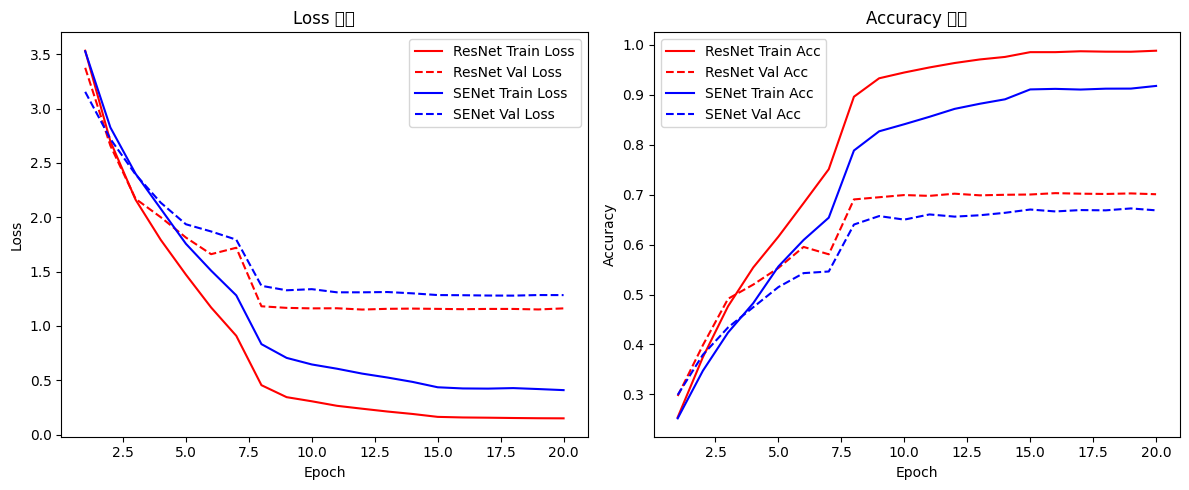

In [9]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs+1)
plt.figure(figsize=(12,5))

# Loss 비교
plt.subplot(1,2,1)
plt.plot(epochs, history_resnet['train_loss'], 'r-', label='ResNet Train Loss')
plt.plot(epochs, history_resnet['val_loss'], 'r--', label='ResNet Val Loss')
plt.plot(epochs, history_senet['train_loss'], 'b-', label='SENet Train Loss')
plt.plot(epochs, history_senet['val_loss'], 'b--', label='SENet Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss 비교')
plt.legend()

# Accuracy 비교
plt.subplot(1,2,2)
plt.plot(epochs, history_resnet['train_acc'], 'r-', label='ResNet Train Acc')
plt.plot(epochs, history_resnet['val_acc'], 'r--', label='ResNet Val Acc')
plt.plot(epochs, history_senet['train_acc'], 'b-', label='SENet Train Acc')
plt.plot(epochs, history_senet['val_acc'], 'b--', label='SENet Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy 비교')
plt.legend()

plt.tight_layout()
plt.show()

## Caltech‑101 데이터셋 요약

- 101개 클래스, 총 9144 장

- 각 클래스별 이미지 수는 클래스에 따라 다름

- 어노테이션 파일 존재 (다만, 객체 탐지가 아닌 이미지 분류 문제라 사용하지는 않음)

## 적용한 학습 기법

- SE (Squeeze-and-Excitation) 모듈 적용 (SENet)

  - Global Average Pooling을 통해 각 채널의 전역 통계를 계산한 후, 두 개의 1×1 컨볼루션 연산(채널 감소 및 복원)과 활성화 함수(ReLU, Sigmoid)를 적용하여 각 채널별 가중치 학습
  
  - 채널별 가중치를 원래 입력에 곱해주어, 중요한 채널은 강조하고 덜 중요한 채널은 억제

- 데이터 전처리
  - 입력 이미지를 Resize, CenterCrop 등으로 모델 입력 크기(예: 224×224)에 맞게 조정하고, 정규화를 수행

- 가중치 초기화
  - Kaiming Normal Initialization을 사용해 각 컨볼루션 레이어의 가중치를 초기화하여 학습 초반 안정성을 확보

## 분석 및 고찰

- ResNet18

  - 기본 residual 구조를 통해 안정적인 학습과 효과적인 특징 추출을 기대하였습니다.
  - 학습과 검증 손실이 점진적으로 감소하며, 정확도가 향상되는 추세를 보이다가 8epoch 쯤 부터는 70%정도에 머물렀습니다.
  - 클래스 당 이미지의 수가 제한적이라 더 높은 정확도가 나오지 못했다고 생각합니다.

- SENet (ResNet18 베이스)

  - SE 모듈을 통해 채널 재조정 효과가 반영되어, 동일 조건에서 기본 ResNet18보다 성능 향상될 것이라 기대하였습니다.
  - 하지만 결과는 SENet의 성능이 좀 더 낮았고 이렇게 된 이유에는 기본적으로 ResNet18은 정형화된 정석적인 코드를 가져와 사용하였고 SENet은 따로 구현을 하였기 때문에 정확도가 떨어질 수 있다고 생각하였고, 아니면 완전히 동일한 하이퍼파라미터를 사용하였는데 SENet은 ResNet18과 비교하여 더 복잡한 연산을 수행하기 때문에 하이퍼파라미터를 달리해야 성능이 향상될 것이라 생각하였습니다.

## 어려웠던 점

- Caltech‑101 데이터셋이 생소하였고 처음엔 압축 파일 안에 파일이 여러가지 있어서 무엇을 사용해야할지 몰라 어려움을 겪었습니다. 검색을 통해 어노테이션은 객체의 위치와 바운딩 박스와 같은 정보를 포함한 파일이란 것을 알게 되었고 지금은 이미지 분류 문제이기 때문에 사용하지 않는 것으로 해결하였습니다.

- 별도의 Test 데이터셋이 없어서 임의로 80:20인 검증 데이터셋을 만들었는데 만약 데이터 불균형 문제가 발생하였다면 알 수가 없어서 곤란한 상황입니다. 해결할만한 마땅한 방법이 떠오르지 않았습니다.

- ResNet18은 저번 과제에서 구현해 보아서 pytorch에 구현되어 있는 모델을 가져다 사용하였고 SENet은 직접 서치와 생성형 AI를 참고하여 구현해보았는데 이론은 이해가 되었지만 실제로 구현하려 해보니 헷갈리는 점이 많아서 어려웠습니다.